# Module 7 - Data augmentation

Often times, the number of images per class in the labeled datasets we work with are limited by a variety of factors. This is sometimes due to natural variablitiy in the population being observed. Other times, due to contraints in terms of human annotation costs. The result is that the distribution of classes in the trainin set is uneven.

In principle, having an uneven training set is not an issue if it the disparity between the classes reflects the natural population. But in the ocean, populations can fluctuate so rapidly in time and space, it is sometimes preferable to have a classifier trained on a uniform class distribtution. This in effect biases the classifier to think each type of organism is equally likely to be imaged. 

Ideally, there would be enough training images that one could simply subsample each class until the distribution is uniform. But as with the SPC training data provided for the workshop, this is often not the case. One solution is to use *data augmentation* to artifically increase the size of certain classes.

The process of data augmentation involves poking and proding images to look subtly different using the image transformations described in module 2. Then as the network is being trained, it is shown different versions of the same organism. Caution needs to be exercised when using this procedure. It is very easy to overfit the classifier to your data.

In [1]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import os
import sys
import copy
import glob
import random
from tqdm.notebook import trange, tqdm

Instead of using OpenCV, we will use pytorch's image transformations. These can be used with the Compose class that is used to convert RBG images to a tensor. Pytorch has several, common built-in transforms. There is also a *lambda* class that allows users to define custom transforms.

First, set up a little plotting function that takes two PIL images as input and plots them with certain parameter. This will prevent cutting and pasting a lot of code down below.

In [2]:
def plot_transform_imgs(orig_img, trn_img):
    """
    routine to plot two images stacked on top of each other. No axis ticks or labels. Titles hardcoded
    :param orig_img: untransformed PIL image
    :param trn_img: transformed PIL image
    :return :
    """

    # initalize a 2x1 plot
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 7))
    ax[0].set_title('original')
    ax[0].imshow(np.asarray(orig_img))
    ax[1].set_title('transform')
    ax[1].imshow(np.asarray(trn_img))
    
    # turn off axis ticks in both\n",
    for xx in ax:
        xx.set_xticks([])
        xx.set_yticks([])
        
    # display the plot
    plt.show()

## Random flips

To start, lets look at just one transformation: RandomHorizontalFlip.

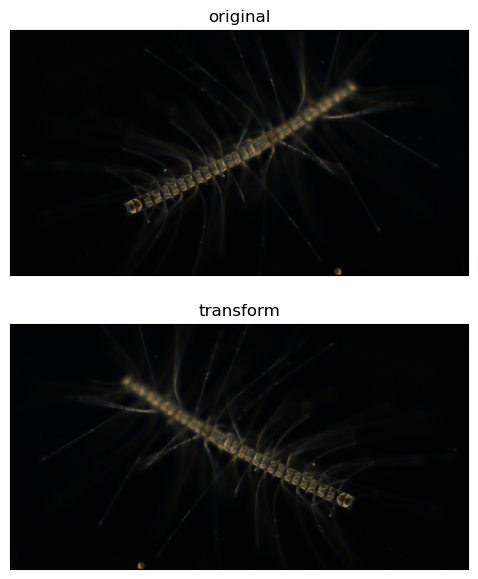

In [6]:
# A random flip transformation
rand_flip = transforms.Compose([
    transforms.RandomHorizontalFlip()
    ])

# load the image
ptf = glob.glob(os.path.join(os.getcwd(), 'computer-vision-workshop/SPC*'))

# we will load images with Python Image Library (PIL). 
img_orig = Image.open(ptf[0])

# do the flip
test = rand_flip(img_orig)

# display it
plot_transform_imgs(img_orig, test)

Did the image show up upside down? Try running the block again. RandomHoizontalFlip will only flip an image with a probability of 0.5.

The same is true of the RandomVerticalFlip function.

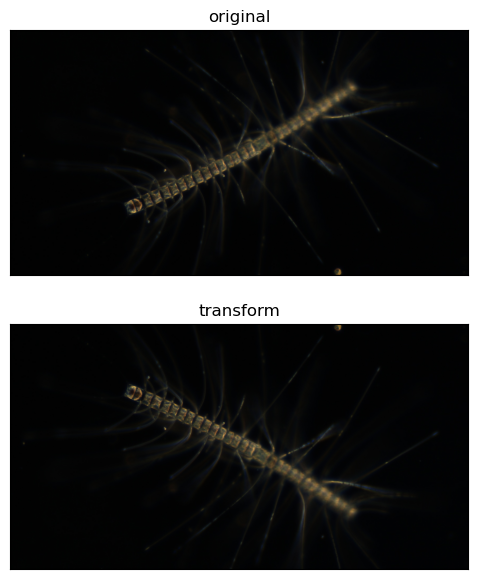

In [8]:
# redefine the random flip composer
rand_flip = transforms.Compose([
    transforms.RandomVerticalFlip()
])

# do the flip
test = rand_flip(img_orig)

# display i
plot_transform_imgs(img_orig, test)

The transformations can be chained together. The probability of a flip is independent in each step.

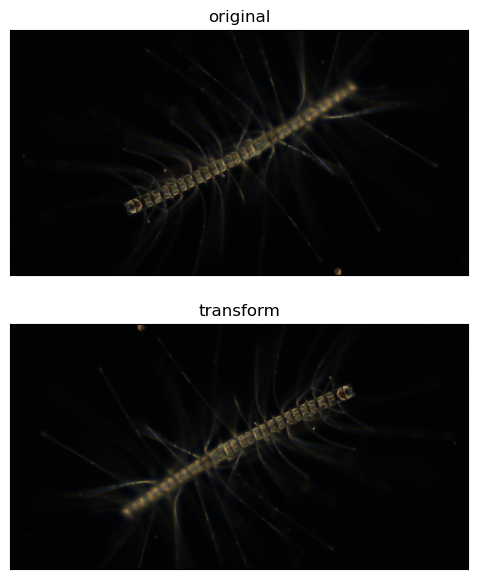

In [10]:
# redefine the random flip composer
rand_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

# do the flip
test = rand_flip(img_orig)

# display it
plot_transform_imgs(img_orig, test)

## Random Affine

Pytorch has a [RandomAffine](https://pytorch.org/docs/0.4.0/torchvision/transforms.html#torchvision.transforms.RandomAffine) module that encompasses many affine transformations:

    * rotation
    * translations
    * scaling
    * shearing
    
To see how they work, we will go through one-by-one starting with rotation, the first argument in the RandomAffine transform. To use it, define the range of allowable angles for the rotation.

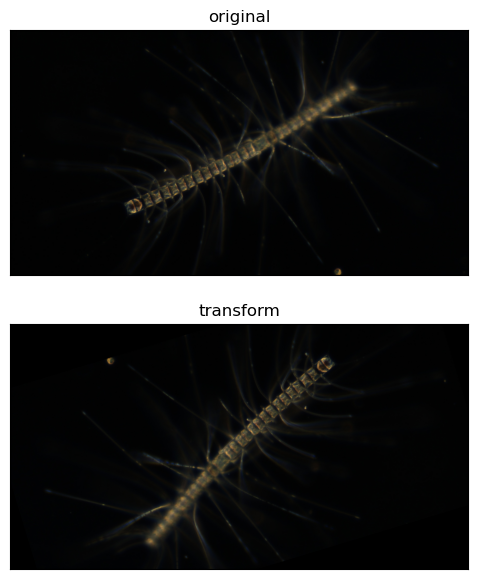

In [11]:
# define a random rotation 
rand_affine = transforms.Compose([
    transforms.RandomAffine((0, 360))  # (min_angle, max_angle)
])

# do the flip
test = rand_affine(img_orig)

# display it
plot_transform_imgs(img_orig, test)

To translate without rotating, set the first argument to 0 and put in an argument for translate. To use it, you define the maximum fraction of the images dimensions to shift it. 

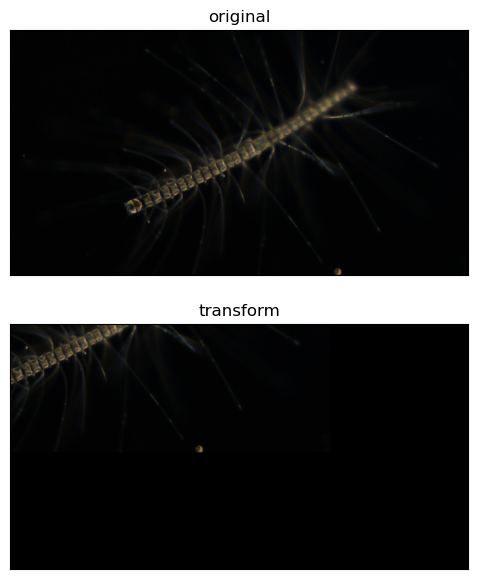

In [12]:
# define a random translation
rand_affine = transforms.Compose([
    transforms.RandomAffine(0, translate=(0.5, 0.5))  # (max_width, max_vertical)
])

# do the flip
test = rand_affine(img_orig)

# display it
plot_transform_imgs(img_orig, test)

Scaling artifically zooms in or out on the image. To set it, define a range of allowable scaling factors. A scale factor of 1 keeps the ROI the same size. In the following code block, we randomly scale an image between half size and 1.5 times the size. 

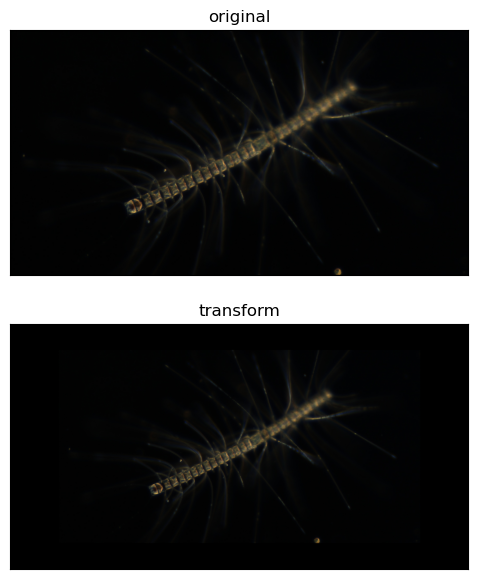

In [13]:
# define a random scale transform 
rand_affine = transforms.Compose([
    transforms.RandomAffine(0, scale=(0.5, 1.5))  # (min_scale, max_scale)
])

# do the flip
test = rand_affine(img_orig)

# display it
plot_transform_imgs(img_orig, test)

Lastly, an image can be sheared by a randomly selected range of values of degrees. You can enter a range or a single value. A single value will be treated as a range defined as (-val, +val).

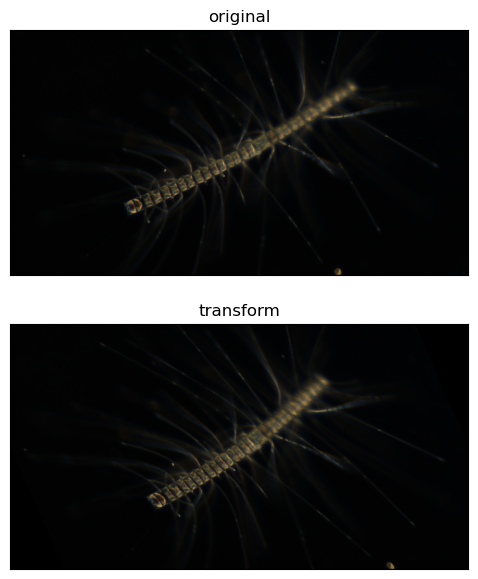

In [14]:
# define a random shear 
rand_affine = transforms.Compose([
    transforms.RandomAffine(0, shear=50)  # (min_angle, max_angle)
])

# do the flip
test = rand_affine(img_orig)

# display it
plot_transform_imgs(img_orig, test)

As with the other transforms, these can all be chained together. 

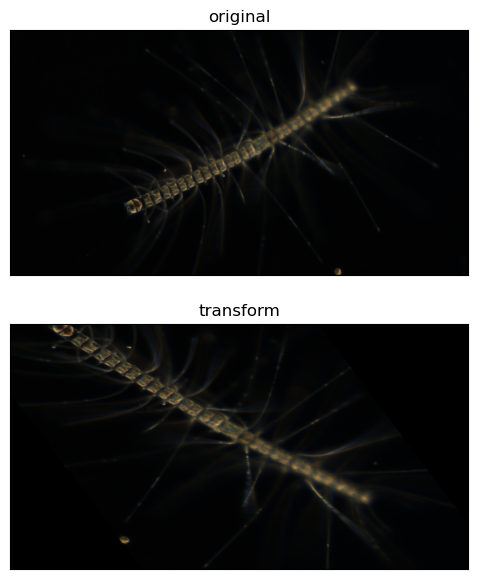

In [15]:
# do a bunch of random transforms 
rand_affine = transforms.Compose([
    transforms.RandomAffine((0, 360),  # (min_angle, max_angle)
                            translate=(0.25, 0.25), # (max_width, max_vertical)
                            scale=(0.5, 1.5),  # (min_scale, max_scale)
                            shear=30  # angle
                           )  
])

# do the flip
test = rand_affine(img_orig)

# display it
plot_transform_imgs(img_orig, test)

These sorts of transformations are useful for making limited data appear more abundant to a machine classifier during training. Chaining them together can cause the classifier to learn a richer representation of the organisms than would be possible with raw data alone. 

## Custom Augmentation

Depending on your imaging scenario, it can be useful to design a custom augmentation method. The SPC, for example, is a free body imaging system. It has a fixed focal plane and objects can drift in and our of focus. It might be helpful to train the classifier to recogonize an object even it if is blurry.

A 2-D Gaussian kernel is a useful model for blur. If we wish to use a Gaussian blur kernel on the data in line with the rest of the data transforms, we can use a *Lambda* function. It will apply a user defined transform.

In [50]:
# First define a Gaussian blur funtion with PIL
def gauss_blur(img, max_blur=9):
    """
    Uses PIL to blur an image with a random kernel size
    :param img: PIL image to blur
    :param max_blur: max width of blur kernel
    :return : blurred image
    """
    
    # randomly select a blur kernel (ensuring it is an odd number)
    amt = np.random.choice(np.arange(1, max_blur, 2))
    
    # blur the image with PIL
    img = img.filter(ImageFilter.GaussianBlur(int(amt)))
    
    return img

This function will blur the input image. We can run it byitself in a pytorch transform

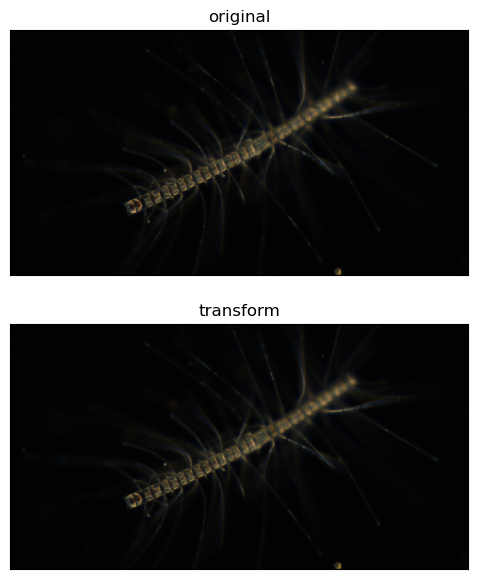

In [51]:
# define a gaussian blur 
rand_affine = transforms.Compose([
    transforms.Lambda(lambda x: gauss_blur(x))
])

# do the flip
test = rand_affine(img_orig)

# display it
plot_transform_imgs(img_orig, test)

In the case of the SPC, this can make for a more robust classifier that will have to recognize blurry images in the field. Again, a lambda function can be chained with the other affine transforms.

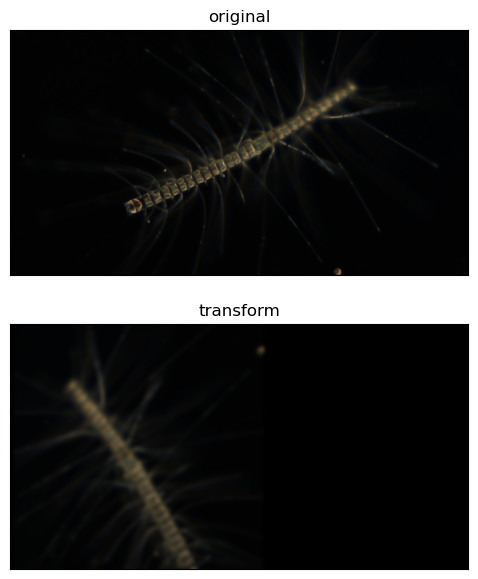

In [52]:
# do a bunch of random transforms 
rand_affine = transforms.Compose([
    transforms.RandomAffine((0, 360),  # (min_angle, max_angle)
                            translate=(0.25, 0.25), # (max_width, max_vertical)
                            scale=(0.5, 1.5),  # (min_scale, max_scale)
                            shear=30  # angle
                           ),
    transforms.Lambda(lambda x: gauss_blur(x))
])

# do the flip
test = rand_affine(img_orig)

# display it
plot_transform_imgs(img_orig, test)


## A word of caution

Data augmentation does comes with a few caveats. 

* It must be done intelligently and reasonably. You do not want to warp your images beyond human recognition -- this would cause the classifier to learn irrevalent features of the data. 
* It should be done relatively conservatively. Feeding a network too many augmented version of the same image can cause it to overfit to the limited data. That is, the classifier will only learn to distinguish between many variations of the same image. 

## Exercises

Eric and Martin trained the pytorch model 'spc_resnet.pt' offline using these techniques and saved the weights using ['torch.save'](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model). The data used for the training are stored in '../Data/SPC_resnet18_domain_adapt' with in the usual format. If you go into the directory, you will note that the number of images per class is the same across the board. This was done by subsampling the biggest classes and duplicating the small ones.

As the training images are fed to the classifier, the following augmentation procedure was used.

In [41]:
# the transform 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine((0, 360), 
                            translate=(0.25, 0.25),
                            scale=(0.5, 1.5), 
                            shear=30 
                           ),
    transforms.Lambda(lambda x: gauss_blur(x)),
    transforms.ToTensor()
])

Load the trained network with torch and apply it to the validation set and compare it to the output of the exercise from Module 6 where ResNet18 was trained on unaugmented SPC data. Which network performed better on the validation set?

In [ ]:
# load the network weights
spc_model = torch.load('spc_resnet.pt')

# set it to evaluation mode
spc_model.eval()

In the code block below, go ahead and execute the same evalutation from Module 6: run through the validation set, save the output, and plot it. Compare the performance to the SPC dataset that was unaugmented. What do you notice?